In [1]:
import seaborn as sns

sns.set_context("talk")

%config InlineBackend.figure_format = 'retina'

# Watch how AI learns to classify images

## Looking under the hood of machine learning routines while they learn about things.

---

There exist already many tutorial and demos that show nicely how machine learning routines can learn from images and do wondrous tasks. And so, this article is not about what they can do, nor about the code to get there, but about what's happening while the machines are learning.

I hope that the animations in this article can show in an intuitive way, how current machine learning routines start from randomness and learn very quickly how to extract meaningful features from data to solve a given task in a efficient and impressive way. So let's jump right into it!

## The data set

First things first, we need a data set and a problem. Mixing things up slightly, lets use the Fashion MNIST dataset and a classification task. In short, the Fashion MNIST contains 70'000 Zalando clothing items, where each item is a 28 x 28 pixel, gray-scaled image, belonging to 10 different clothing categories.

In [2]:
import numpy as np
import tensorflow as tf

# Load and prepare dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_tr, y_tr), (X_te, y_te) = fashion_mnist.load_data()
labels = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
labels_tr = np.array([labels[j] for j in y_tr])
labels_te = np.array([labels[j] for j in y_te])

Before going any further, let's take a quick look at a few of these images.

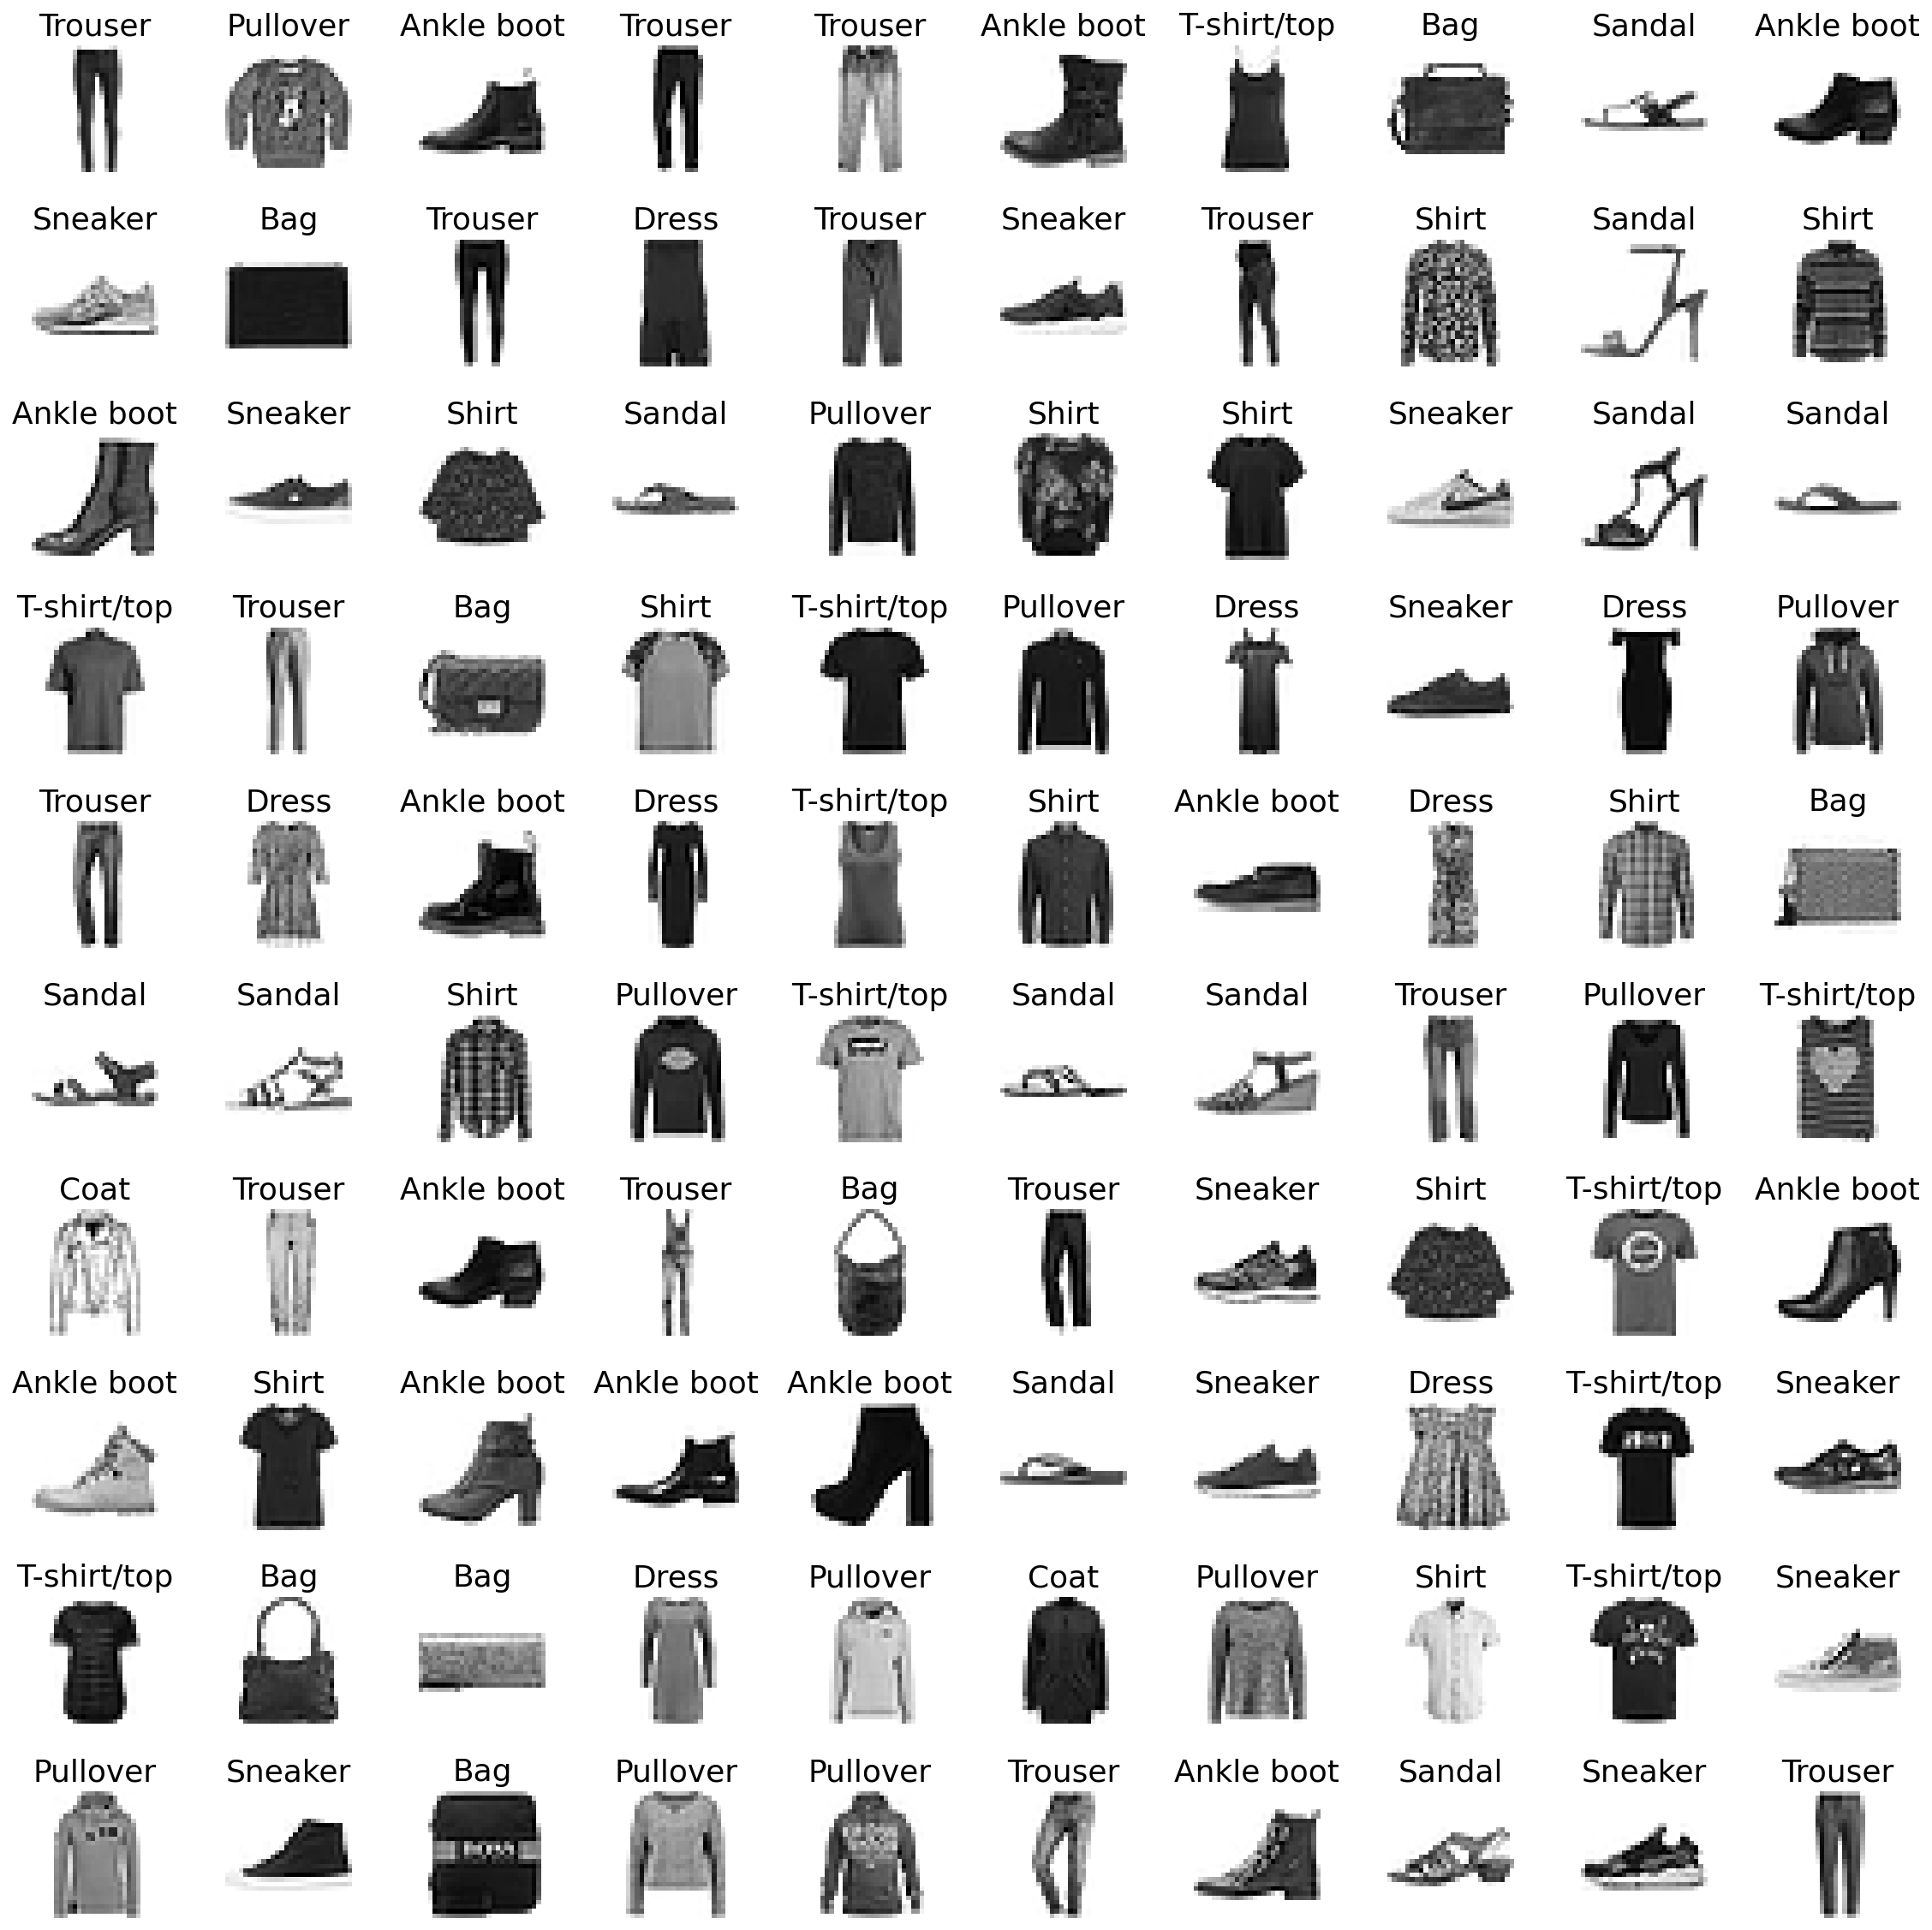

In [3]:
import matplotlib.pyplot as plt

# Plot a few random clothing items
size = 10
idx = np.random.choice(np.arange(len(y_tr)), size ** 2 * 2)
fig, axes = plt.subplots(size, size, figsize=(16, 16))
for i, ax in enumerate(axes.flatten()):
    ax.set_title(labels_tr[idx][i])
    ax.imshow(X_tr[idx][i], cmap="binary")
    ax.axis("off")
    ax.set_aspect("equal")
plt.tight_layout()

Looking at these images we can see that some categories look rather homogenious, while others are quite diverse. So let's take a closer look at these target categories (i.e. classes) and how they might relate to each other.

A simple way to do this is by looking at the class averages and investigating how they correlate to each other.

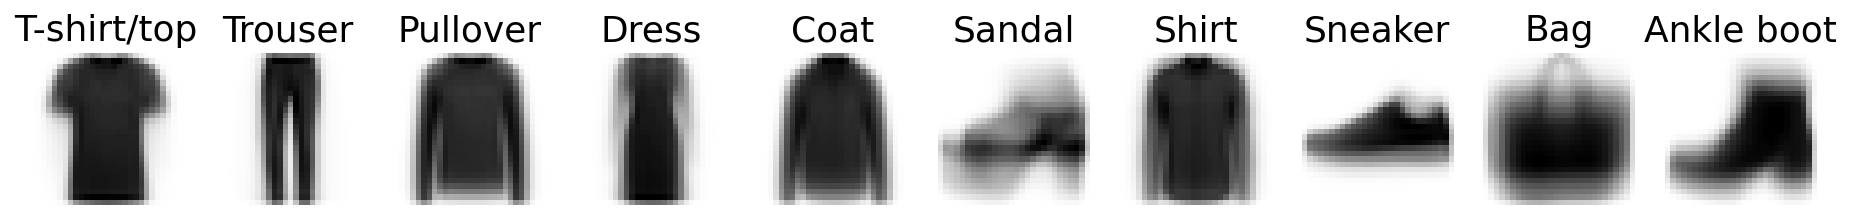

In [4]:
# Look at class averages
class_averages = []
fig, axes = plt.subplots(1, 10, figsize=(16, 3))
for i, ax in enumerate(axes.flatten()):
    ax.set_title(labels[i])
    class_average = np.mean(X_tr[y_tr == i], axis=0) / 255
    class_averages.append(class_average)
    ax.imshow(class_average, cmap="binary")
    ax.axis("off")
    ax.set_aspect("equal")
plt.show()

As we assumed, categories like `Trouser`, `Pullover` and `T-shirt/top` are rather heterogenous (i.e. sharp), while `Dress`, `Sandal` and `Bag` are a bit vague.

And how do these classes relate to each other? For this we will just simply investigate how correlated each of these pixels are with each other, and then order this correlation matrix, by using seaborn's hierarchically-clustered heatmap.

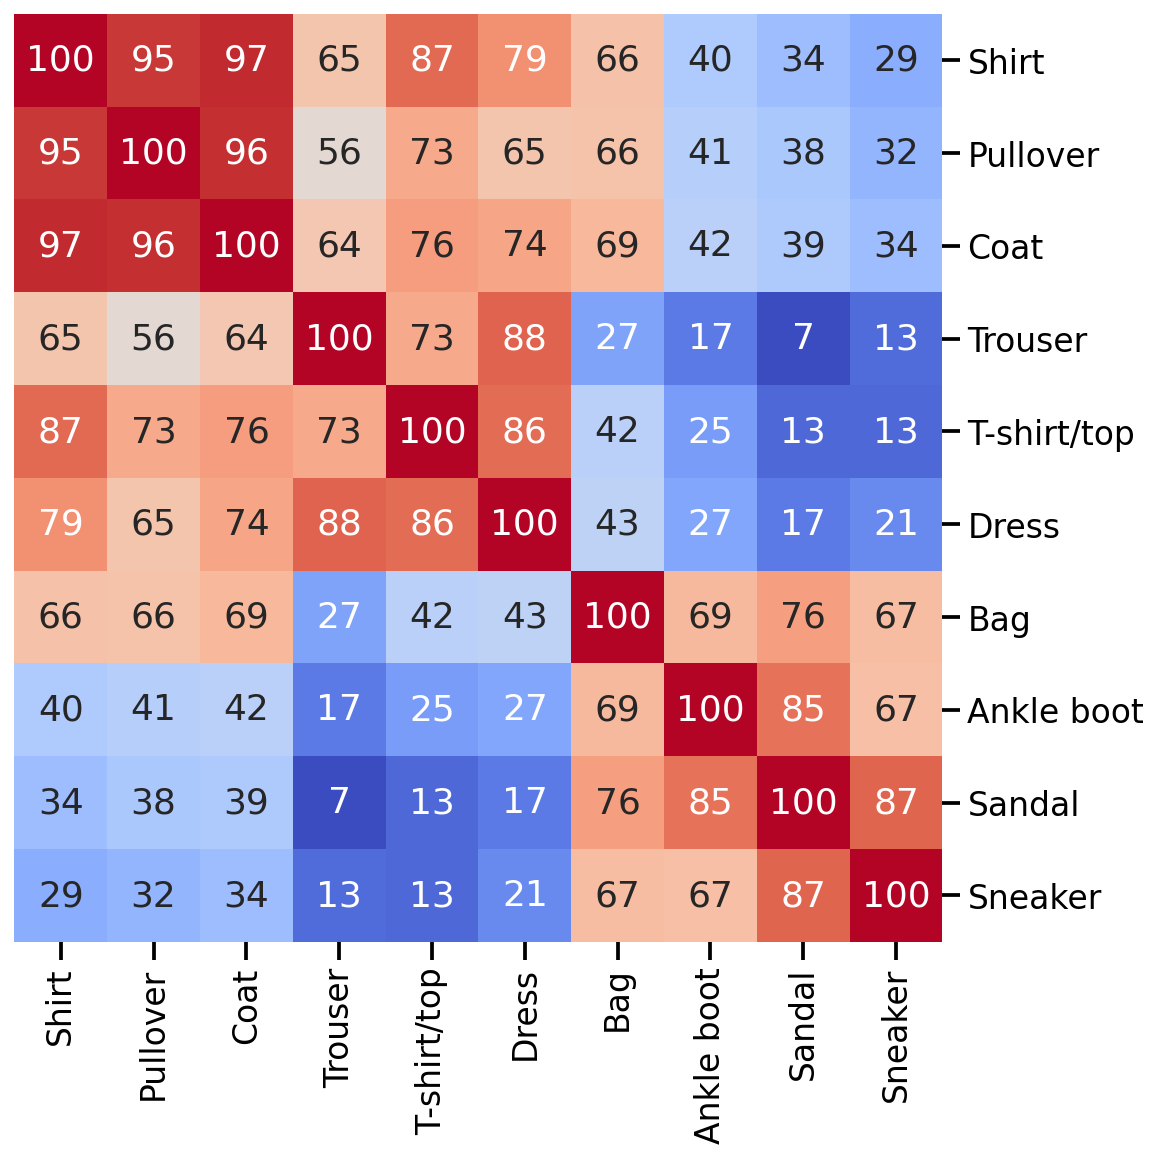

In [5]:
import pandas as pd
import seaborn as sns

# Correlate class averages and plot hierarchically-clustered heatmap
corr = np.corrcoef(np.reshape(class_averages, (10, -1)))
df_corr = pd.DataFrame(corr, index=labels, columns=labels)
cm = sns.clustermap(
    100 * df_corr,
    cmap="coolwarm",
    annot=True,
    cbar=False,
    fmt=".0f",
    figsize=(10, 10),
)
cm.ax_row_dendrogram.set_visible(False)
cm.ax_col_dendrogram.set_visible(False)
cm.cax.set_visible(False)
plt.show()

Great, there seems to be some structure. Given this correlation matrix, we could assume that a machine learning model will have more problem to differentiate `Shirt`, `Pullover` and `Coat` from one another than from other classes. Similar thing for `Sandal` and `Sneakers`, etc.

# Unsupervised Learning

Now that we know our data set a bit better and have an intuition for where our machine learning models might struggle, we can go ahead and train them. First, let's start with an unsupervised learning approach, specifically with [UMAP](https://umap-learn.readthedocs.io/en/latest/), i.e. Uniform Manifold Approximation and Projection for Dimension Reduction.

The details about how UMAP works are not important here, but what you should know is the following: This unsupervised learning method tries to find a lower-dimensional manifold on which our high-dimensional data set lies. Once this manifold is known (or estimated), we can try to unfold and flatten it onto a 2-dimensional plane and visualize it in a human-understandable form. In contrast to other similar approaches (e.g. t-SNE), UMAP allows the reduction to more than just two dimensions and also contains a `.transfrom()` function, meaning that the mapping can even be reversed for new samples in the dataset.

So, let's see the process in action!

In [6]:
import umap

# Get samples into a 1D shape
data = X_tr.reshape(-1, 28 ** 2) / 255.0

# Train UMAP model
transformer = umap.UMAP(
    n_neighbors=15,
    random_state=24,
    learning_rate=0.33,  # Lower than usual to slow down model improvement for visualization
    min_dist=0.2,  # Chosen to lead to a nice final spread of point cloud
    n_epochs=128,
    n_jobs=1,  # Keeping it sequential to extract epochs one after the other
)
embedding = transformer.fit_transform(data)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


As many such machine learning models, the model is initiated with more or less random parameters and then slowly optimizes to an impressive end result. To fully appreciate how well this works, it is important to understand that this routine doesn't know about the target classes, and as such only works with similarities in the high-dimensional space.

In [7]:
import matplotlib.patheffects as PathEffects


def plot_umap(embedding, y_tr, labels, step):

    fig, ax = plt.subplots(1, figsize=(11, 10))
    ax = plt.subplot(aspect="equal")

    plt.scatter(*embedding.T, s=0.4, c=y_tr, cmap="Spectral", alpha=1.0)
    if step == 1:
        title_txt = "Original data"
    elif step == 121:
        title_txt = "Transformed Data"
    else:
        title_txt = "Iteration Step: %03d" % step
    plt.title(title_txt, fontsize=28)

    cbar = plt.colorbar(boundaries=np.arange(11) - 0.5)
    cbar.set_ticks(np.arange(10))
    cbar.set_ticklabels(labels)

    plt.xlim(-5, 17)
    plt.ylim(-7, 16)
    ax.axis("off")

    # We add the labels for each class
    for i, t in enumerate(labels):
        # Position of each label
        xtext, ytext = np.median(embedding[y_tr == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(t), fontsize=24)
        txt.set_path_effects(
            [PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()]
        )
    plt.tight_layout()

    return fig

In [ ]:
for n in range(128):
    fig = plot_umap(np.load("emb_%04d.npz" % n)["embedding"], y_tr, labels, n)
    fig.savefig("fig_%04d.jpeg" % n)
    fig.clf()

In [ ]:
# Remove first figure as it is confusing
!rm fig_0000.jpeg

# Duplicate first and last figure to have a "resting phase" impression
!for i in {1..12}; do cp fig_0001.jpeg fig_0001_$i.jpeg; done
!for i in {1..12}; do cp fig_0127.jpeg fig_0127_$i.jpeg; done

!ffmpeg -y -framerate 12 -pattern_type glob -i 'fig*.jpeg' umap_animation.gif

!rm fig_*.jpeg emb_*.npz

In [10]:
from IPython.display import Image

Image(url="umap_animation.gif")

<IPython.core.display.Javascript object>

Nice, isn't it? What is especially nice to see is that the UMAP projection supports our assumption from the hierarchically-clustered heatmap from before. Or in other words, target classes that are highly correlated with each other also seem to overlap on the lower-dimensional manifold.

<div class="alert alert-success">
  <strong>Note:</strong> To create this animation, you need to slightly adapt UMAP's source code (<a href="https://github.com/lmcinnes/umap/blob/c060b65c208f3fdfd8abf1296adb4d9882cdac4e/umap/layouts.py#L396">here</a>) and save each `head_embedding` to a new file (e.g. `np.savez(filename, embedding=head_embedding)`. 
</div>

## Supervised Learning

Let's now explore what we can do if we chose a supervised learning approach and provide the machine learning model with the target class labels. While this would also be possible with a UMAP approach, let's switch gears a bit and use a **convolutional neural network**, or short CNN, instead. A CNN is a particular kind of neural network that is specialized for analyzing data with spatial structure (e.g. images or time-series data).

In short, what a CNN tries to do is the fllowing: Find meaningful patterns in an image that help to differentiate target classes. For example, does one class of images have more straight lines than others, or more "wavy bits"? Do some images have more dots or wrinkles, do they have handles or shoe laces, etc. The CNN tries to find specific image patterns that are unique to some classes. Once it knows what kind of patterns can be found, it can use this information to predict if an image looks more than one class or another.

To better illustrate the wonder of such CNNs, let's also go to a bit more naturalistic dataset: The [CIFAR-10](https://en.wikipedia.org/wiki/CIFAR-10). Similar to the Fashion-MNIST dataset, this data set contains 70'000 color images, with a pixel resolution of 32 x 32, of 10 different target classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck. Let's have a quick look at this dataset:

In [8]:
import numpy as np
import tensorflow as tf

# Load and prepare dataset
(X_tr, y_tr), (X_te, y_te) = tf.keras.datasets.cifar10.load_data()
y_tr = y_tr.ravel()
y_te = y_te.ravel()

labels = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]
labels_tr = np.array([labels[j] for j in y_tr])
labels_te = np.array([labels[j] for j in y_te])

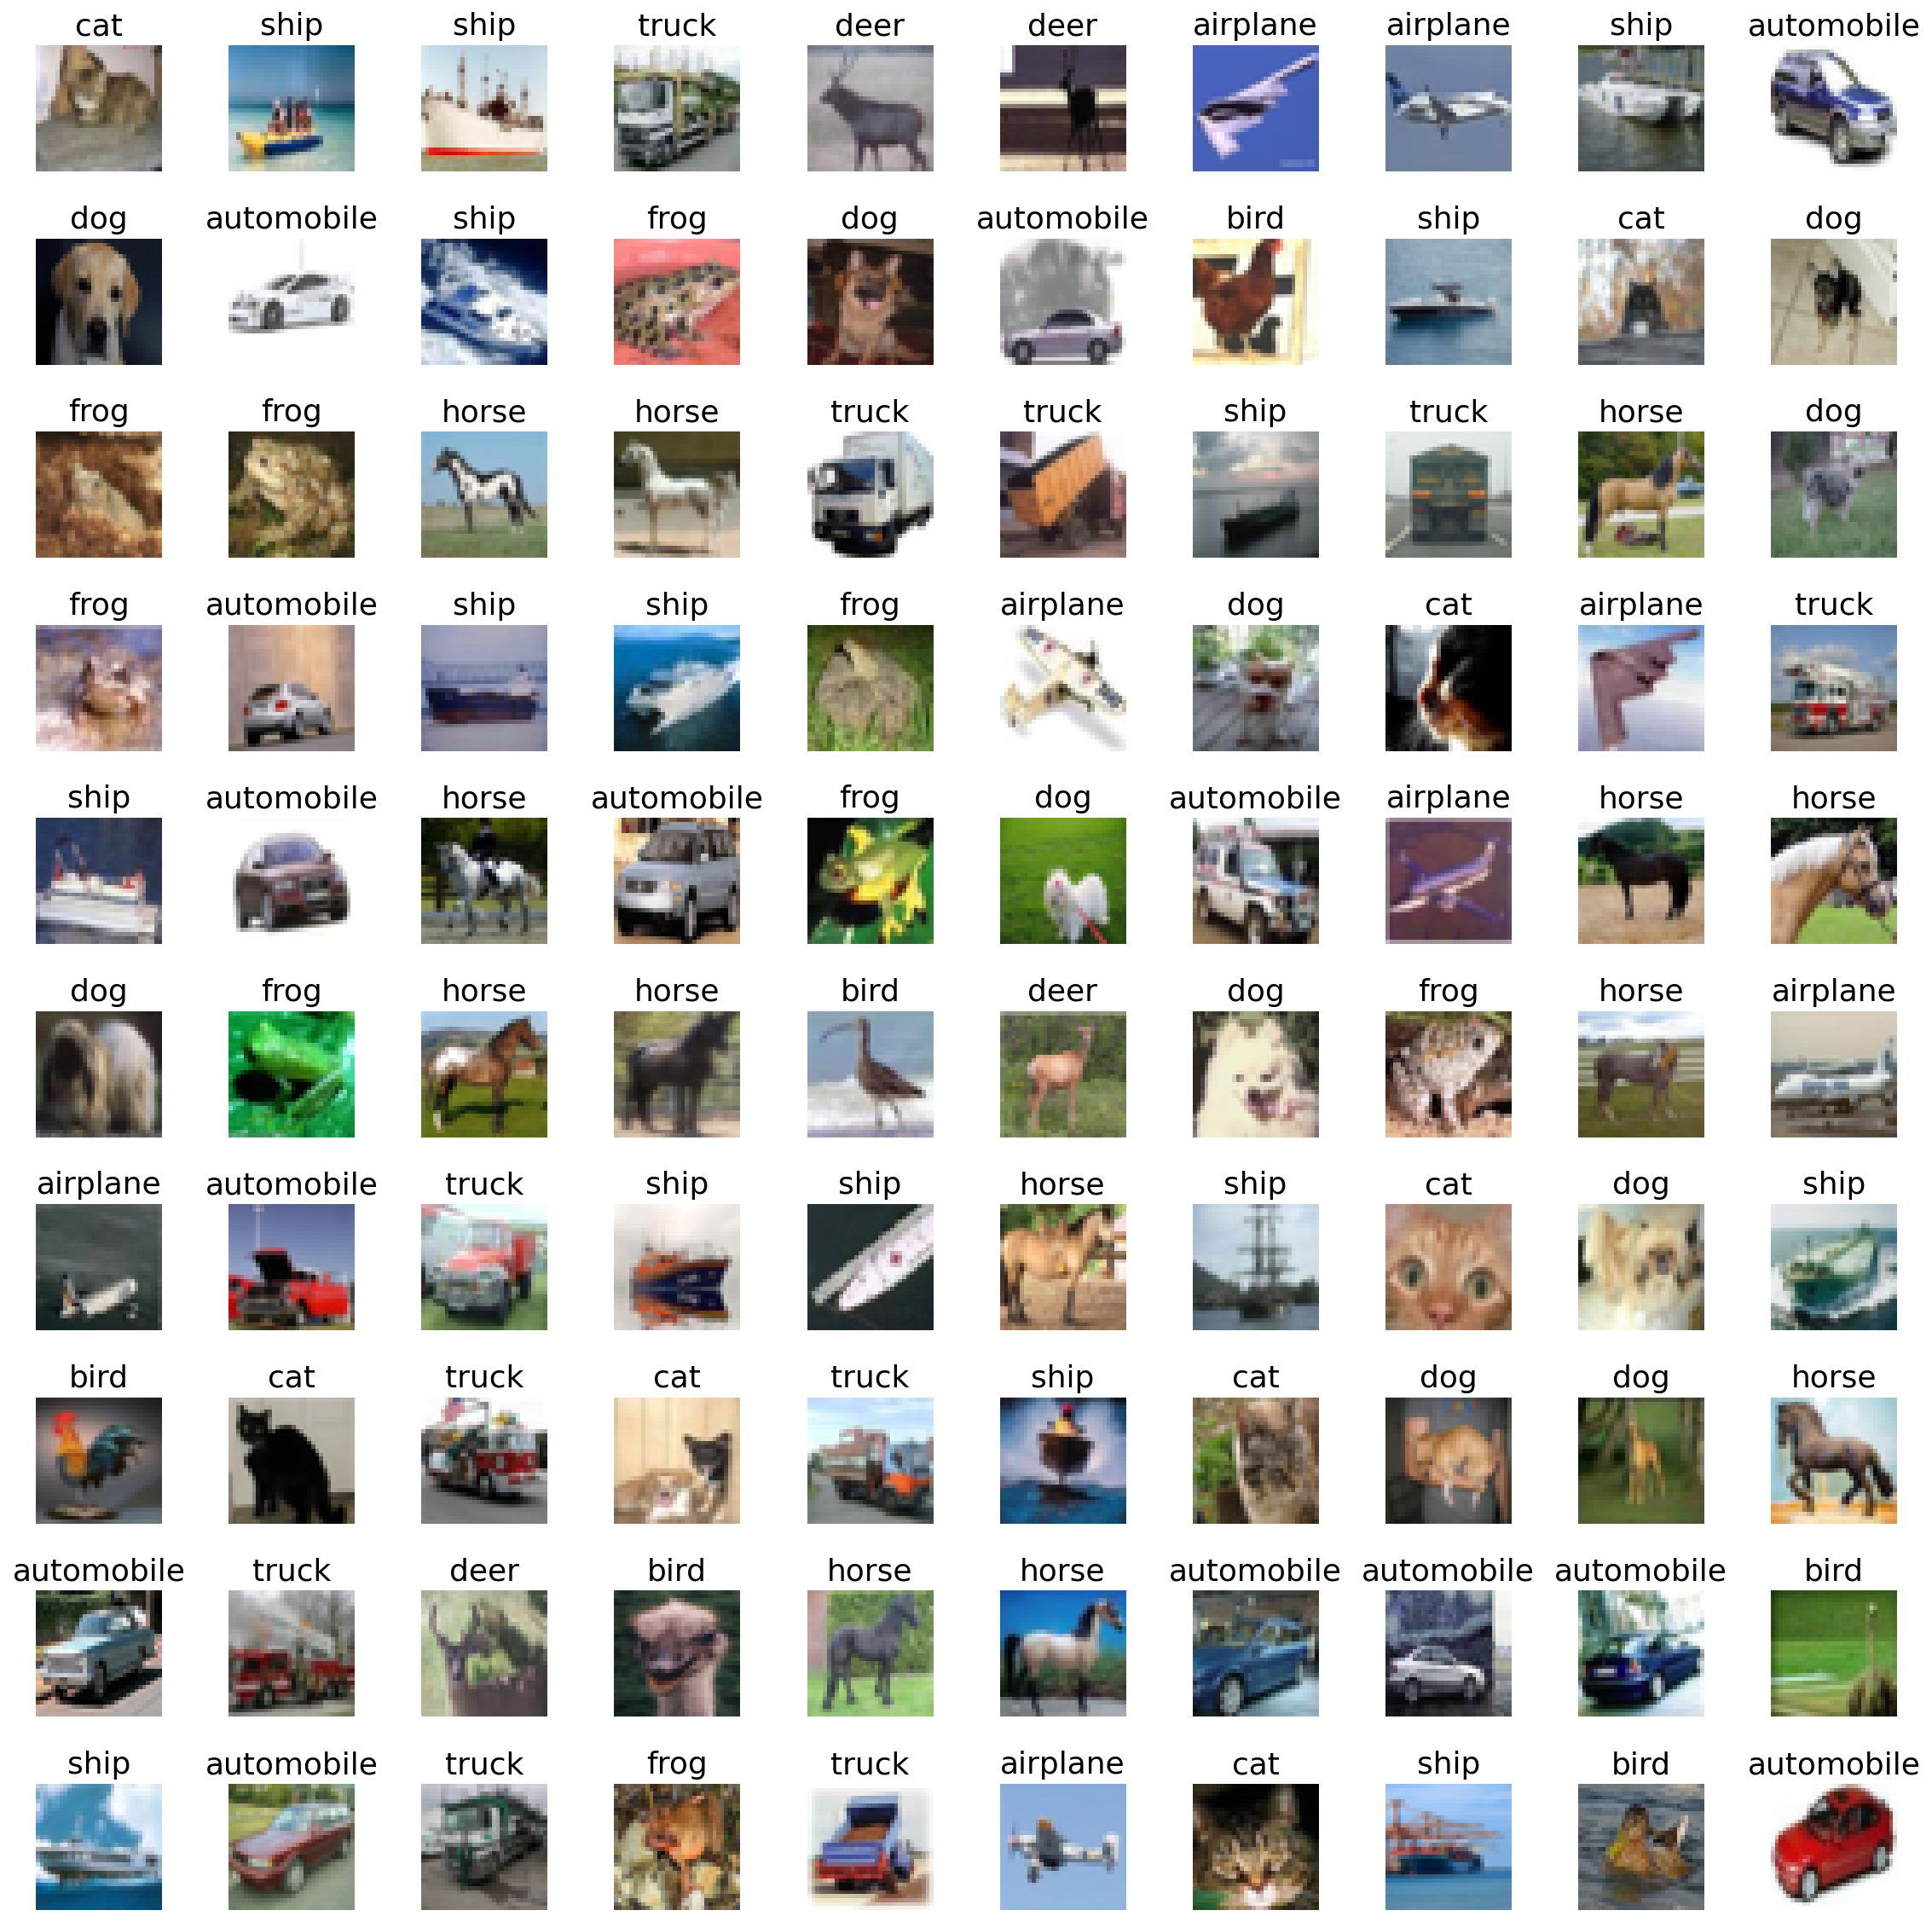

In [9]:
import matplotlib.pyplot as plt

# Plot a few random clothing items
size = 10
idx = np.random.choice(np.arange(len(y_tr)), size ** 2 * 2)
fig, axes = plt.subplots(size, size, figsize=(16, 16))
for i, ax in enumerate(axes.flatten()):
    ax.set_title(labels_tr[idx][i])
    ax.imshow(X_tr[idx][i], cmap="binary")
    ax.axis("off")
    ax.set_aspect("equal")
plt.tight_layout()

## Model creation

Next, let's create a simple convolutional neural network, using TensorFlow:

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [11]:
# Prepare dataset for CNN
x_train = X_tr.astype("float32") / 127.5 - 1
x_test = X_te.astype("float32") / 127.5 - 1

In [12]:
from sklearn.model_selection import train_test_split

# Split train and validation set
x_train, x_valid, y_tr, y_va = train_test_split(
    x_train,
    y_tr,
    test_size=2000,
    stratify=y_tr,
    random_state=0,
)

In [13]:
# Create Conv Net
inputs = tf.keras.Input(shape=(32, 32, 3))

# Entry block
x = layers.Conv2D(
    64,
    kernel_size=(5, 5),
    padding="same",
    kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01, seed=0),
)(inputs)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(2, strides=2)(x)

x = layers.Conv2D(
    64,
    kernel_size=(3, 3),
    padding="same",
    activation="relu",
    kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01, seed=0),
)(x)
x = layers.MaxPooling2D(2, strides=2)(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(
    256,
    activation="relu",
    kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2, seed=0),
)(x)
x = layers.BatchNormalization()(x)

outputs = layers.Dense(10, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                         

2021-12-27 20:50:36.707183: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


This is certainly not the most efficient, nor the best performing network, but it allows us to observe the inner workings of a neural network. But before we go ahead and train the network, let's take a look at the 'raw' and untrained version of it.

In [14]:
def plot_first_layer_kernels(kernels, title=None):

    # Create a grid of subplots
    fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(4, 4))

    # Remove gaps between suplots
    plt.subplots_adjust(wspace=0, hspace=0)

    # Plot the 64 kernels from the first convolutional layer
    for j, axis in enumerate(axes.flatten()):
        # Get i-th kernel (shape: 5x5x3)
        kernel = kernels[:, :, :, j]

        # Rescale values between 0 and 1
        kernel -= kernel.min()  # Rescale between 0 and max
        kernel /= kernel.max()  # Rescale between 0 and 1

        # Plot kernel with imshow()
        axis.imshow(kernel)
        axis.get_xaxis().set_visible(False)  # disable x-axis
        axis.get_yaxis().set_visible(False)  # disable y-axis
    plt.suptitle(title)
    plt.close()
    return fig

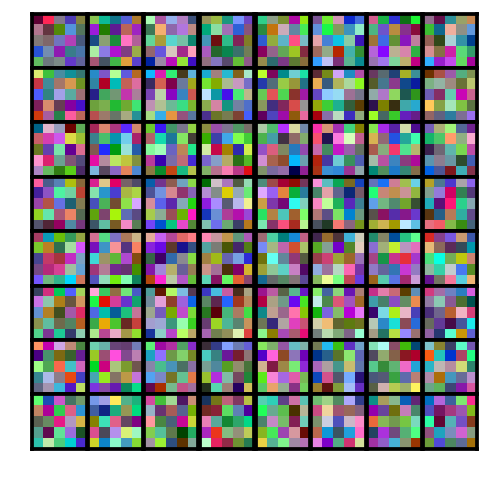

In [15]:
plot_first_layer_kernels(model.get_weights()[0])

Right now, all of the convolutional neural network's parameter are randomly set. In other words, the ConvNet doesn't know what to look for, its 'eyes' are still untrained. And so, if we give this untrained neural network an image to classify, it performs very poorly, and doesn't really know which of the 10 classes to pick from.

In [16]:
def predict_single_image(model, x_test, y_te, labels, idx=0):

    # Compute predictions
    y_pred = model.predict(x_test)

    # Prepare image
    img = np.squeeze(x_test[idx])
    img -= img.min()
    img /= img.max()

    # Get class probabilities
    probability = y_pred[idx] * 100

    # Get class names
    class_names = labels

    # Get predicted and true label of image
    predicted_idx = np.argmax(probability)
    predicted_prob = probability[predicted_idx]
    predicted_label = class_names[predicted_idx]

    import matplotlib.gridspec as gridspec

    # Plot overview figure
    fig = plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    # Plot image
    ax = plt.subplot(gs[0])
    plt.title("Image")
    plt.imshow(img, cmap="binary")
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # Add information text to image
    info_txt = "\nThis is to {:.02f}% a {}!".format(predicted_prob, predicted_label)
    plt.xlabel(info_txt, fontdict={"size": 21})

    # Plot prediction probabilities
    ax = plt.subplot(gs[1])
    plt.title("Prediction Probability")
    y_pos = np.arange(len(probability))
    plt.barh(y_pos, probability, color="#BFBFBF")

    # Set y-label text
    y_label_text = [
        "{}: {:5.2f}%".format(e, probability[i]) for i, e in enumerate(class_names)
    ]
    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_label_text)
    ylim = list(plt.ylim())
    plt.vlines(1 / len(probability) * 100, *ylim, linestyles=":", linewidth=2)
    plt.ylim(ylim)

    plt.tight_layout()
    plt.show()

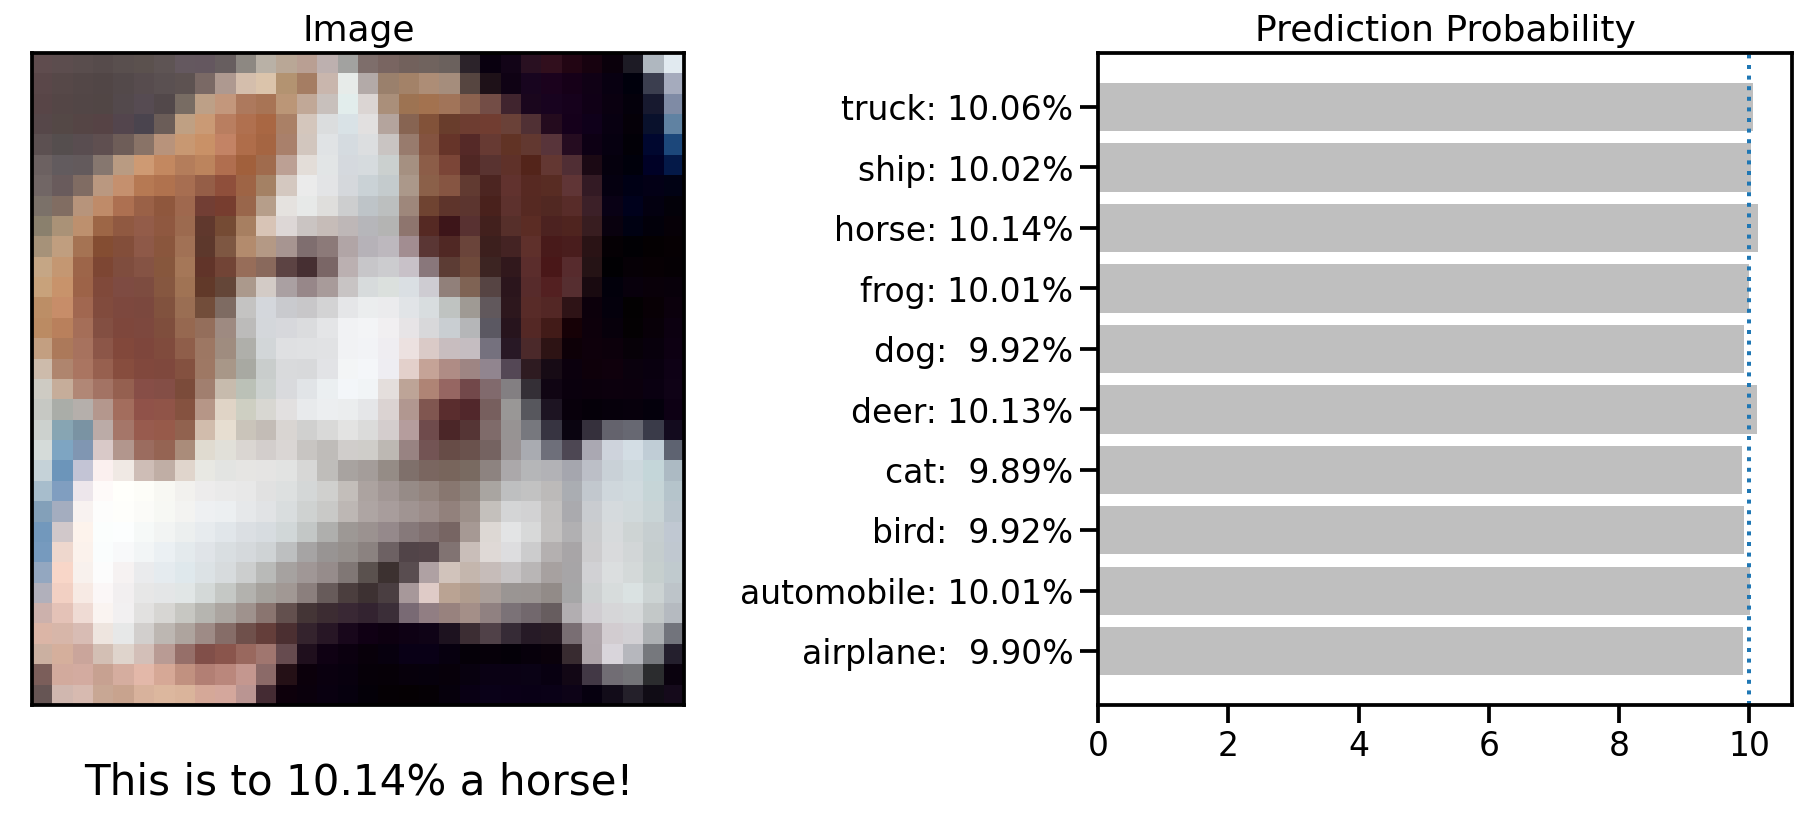

In [17]:
predict_single_image(model, x_test, y_te, labels, idx=16)

In [18]:
import matplotlib.gridspec as gridspec


def predict_multiple_images(
    model, x_test, y_te, labels, nimg=5, seed=0, title_idx=None
):

    # Set random seed
    np.random.seed(seed)

    # Compute predictions
    y_pred = model.predict(x_test)

    from sklearn.utils import shuffle

    imgs = np.squeeze(x_test)
    img_ids = shuffle(np.arange(len(x_test)))

    # Plot first N image prediction information
    fig = plt.figure(figsize=(nimg * 3, 6))
    gs = gridspec.GridSpec(2, nimg, height_ratios=[1, 4])

    for i_pos, idx in enumerate(img_ids[:nimg]):

        # Get image
        img = imgs[idx]

        # Get probability
        probability = y_pred[idx]

        # Get predicted and true label of image
        predicted_label = np.argmax(probability)
        true_label = y_te[idx]

        # Get class names
        class_names = labels

        # Identify the text color
        if predicted_label == true_label:
            color = "#004CFF"
            info_txt = "{} {:2.1f}%\nCorrect!".format(
                class_names[predicted_label], 100 * np.max(probability)
            )
        else:
            color = "#F50000"
            info_txt = "{} {:2.1f}%\nActually: {}".format(
                class_names[predicted_label],
                100 * np.max(probability),
                class_names[true_label],
            )

        # Plot prediction probabilities
        ax = plt.subplot(gs[0, i_pos])
        pred_plot = plt.bar(range(len(probability)), probability, color="#BFBFBF")
        pred_plot[predicted_label].set_color("#FF4747")
        pred_plot[true_label].set_color("#477EFF")
        xlim = list(plt.xlim())
        plt.hlines(1 / len(probability), *xlim, linestyles=":", linewidth=2)
        plt.xlim(xlim)
        plt.ylim((0, 1))
        plt.xticks([])
        plt.yticks([])
        plt.title("Class Probability")

        # Plot image
        ax = plt.subplot(gs[1, i_pos])
        img -= img.min()
        img /= img.max()
        plt.imshow(img, cmap="binary")
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])

        # Add information text to image
        plt.xlabel(info_txt, color=color)

    plt.suptitle(f"Epoch: {title_idx+1}")
    plt.tight_layout()
    fig.savefig("pred_%03d_%04d.jpg" % (seed, title_idx + 1))
    fig.clf()

In [20]:
predict_multiple_images(model, x_test, y_te, labels, nimg=6, seed=0, title_idx=-1)

<Figure size 1296x432 with 0 Axes>

## Model training

Let's now go ahead and train this model. There's an endless depth to explaining how this actually works, but in simple terms, the model looks at a few images (i.e., a batch), tries to predict the target classes of these images, looks at how wrong it was and corrects its internal parameters accordingly.

In [205]:
def plot_first_layer_view(activation_maps, title=None):

    # Create a grid of subplots
    fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(8, 8))

    # Remove gaps between suplots
    plt.subplots_adjust(wspace=0, hspace=0)

    # Plot the activation maps of the 1st conv. layer for the sample image
    for j, axis in enumerate(axes.flatten()):
        # Get activation map of the i-th filter
        activation = activation_maps[0, :, :, j]

        # Rescale values between 0 and 1
        activation -= activation.min()  # Rescale between 0 and max
        activation /= activation.max()  # Rescale between 0 and 1

        # Plot it with imshow()
        axis.imshow(activation, cmap="gray")
        axis.axis("off")

    plt.suptitle(title)
    plt.close()
    return fig

<IPython.core.display.Javascript object>

In [206]:
import numpy as np
import random
import tensorflow as tf

seed_idx = 24
np.random.seed(seed_idx)
random.seed(seed_idx)
tf.random.set_seed(seed_idx)

tf.__version__

'2.7.0'

<IPython.core.display.Javascript object>

In [207]:
scores = []
kernels = []
activations = []

N = 48

for i in range(N):
    history = model.fit(
        x_train,
        y_tr,
        batch_size=((i // 6) + 1) * 10,
        shuffle=True,
        epochs=1,
        validation_data=(x_valid, y_va),
        steps_per_epoch=(i * 2 + 1) * 5,
    )

    # Store kernels in array
    kernels.append(model.get_weights()[0])

    # Store activation maps in array
    img = x_test[16]
    model_conv = tf.keras.Model(model.input, model.layers[1].output)
    activations.append(model_conv.predict(img[None, ...]))

    # Stores scores in array
    scores.append(history.history)

    # Save predictions to image
    for sidx in range(12):
        predict_multiple_images(
            model, x_test, y_te, labels, nimg=6, seed=sidx, title_idx=i
        )

kernels = np.array(kernels)
activations = np.array(activations)
scores = pd.concat([pd.DataFrame(s) for s in scores]).reset_index(drop=True)

15/15 [==============================] - 1s 54ms/step - loss: 2.2300 - accuracy: 0.2667 - val_loss: 2.2876 - val_accuracy: 0.1780


/var/folders/br/r3_jcxsd5nng61zgypxvcjdr0000gp/T/ipykernel_1951/2345562093.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(nimg * 3, 6))


475/475 [==============================] - 42s 88ms/step - loss: 0.2330 - accuracy: 0.9268 - val_loss: 1.1610 - val_accuracy: 0.6630


<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<IPython.core.display.Javascript object>

In [208]:
for idx in range(len(scores)):

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot first layer kernels
    fig_kernel = plot_first_layer_kernels(kernels[idx])
    fig_kernel.savefig("temp.jpg", bbox_inches="tight", pad_inches=0)
    axes[0].imshow(plt.imread("temp.jpg"))
    axes[0].axis("off")
    axes[0].set_title("Kernel")

    # Plot first layer kernels
    fig_activation = plot_first_layer_view(activations[idx])
    fig_activation.savefig("temp.jpg", bbox_inches="tight", pad_inches=0)
    axes[1].imshow(plt.imread("temp.jpg"))
    axes[1].axis("off")
    axes[1].set_title("View")

    # Plot validation curves
    scores[["accuracy", "val_accuracy"]].iloc[: idx + 1, :].plot(
        xlabel="Epochs",
        ylabel="Accuracy",
        xlim=(-0.2, len(scores) - 0.8),
        ylim=(0, 0.9),
        ax=axes[2],
    )
    axes[2].set_title("Learning Curve")

    acc = scores.loc[idx, "val_accuracy"]
    plt.suptitle(f"Epoch: {idx} | Accuracy {acc*100:.2f}%")
    plt.tight_layout()
    fig.savefig("conv_%04d.jpg" % (idx + 1))
    fig.clf()

/var/folders/br/r3_jcxsd5nng61zgypxvcjdr0000gp/T/ipykernel_1951/409984558.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(4, 4))
/var/folders/br/r3_jcxsd5nng61zgypxvcjdr0000gp/T/ipykernel_1951/2654608949.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))


<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<IPython.core.display.Javascript object>

In [211]:
# Duplicate first and last figure to have a "resting phase" impression
!for i in {1..4}; do cp conv_0001.jpg conv_0001_$i.jpg; done
!for i in {1..4}; do cp conv_0048.jpg conv_0048_$i.jpg; done

<IPython.core.display.Javascript object>

In [216]:
!ffmpeg -y -framerate 4 -pattern_type glob -i 'conv*.jpg' cnn_training.gif

ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with clang version 11.1.0
  configuration: --prefix=/Users/mnotter/opt/anaconda3/envs/medium --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --disable-openssl --enable-avresample --enable-demuxer=dash --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-libvpx --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/Users/runner/miniforge3/conda-bld/ffmpeg_1636205445100/_build_env/bin/pkg-config
  libavutil      56. 70.100 / 56. 70.100
  libavcodec     58.134.100 / 58.134.100
  libavformat    58. 76.100 / 58. 76.100
  libavdevice    58. 13.100 / 58. 13.100
  libavfilter     7.110.100 /  7.110.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  9.100 /  5.  9.100
  libswresample   3.  9.

<IPython.core.display.Javascript object>

In [217]:
from IPython.display import Image

Image(url="cnn_training.gif")

<IPython.core.display.Javascript object>

What we can see here is the convolutional neural network learning in action. On the **left**, we can see the different convolutions (also called kernels), the neural network is learning. These are the particular features the network tries to find (e.g. horizontal lines, color shifts from red to green, circular patterns, etc.). In the **middle** we can see how each of these convolutions sees the puppy image from before, and on the **right** we can see how the overall accuracy of the model (on the training and validation set) slowly increases through the 48 epochs we trained the network for.

To verify that the model improved its prediction capability, let's take another look at the puppy classification from before.

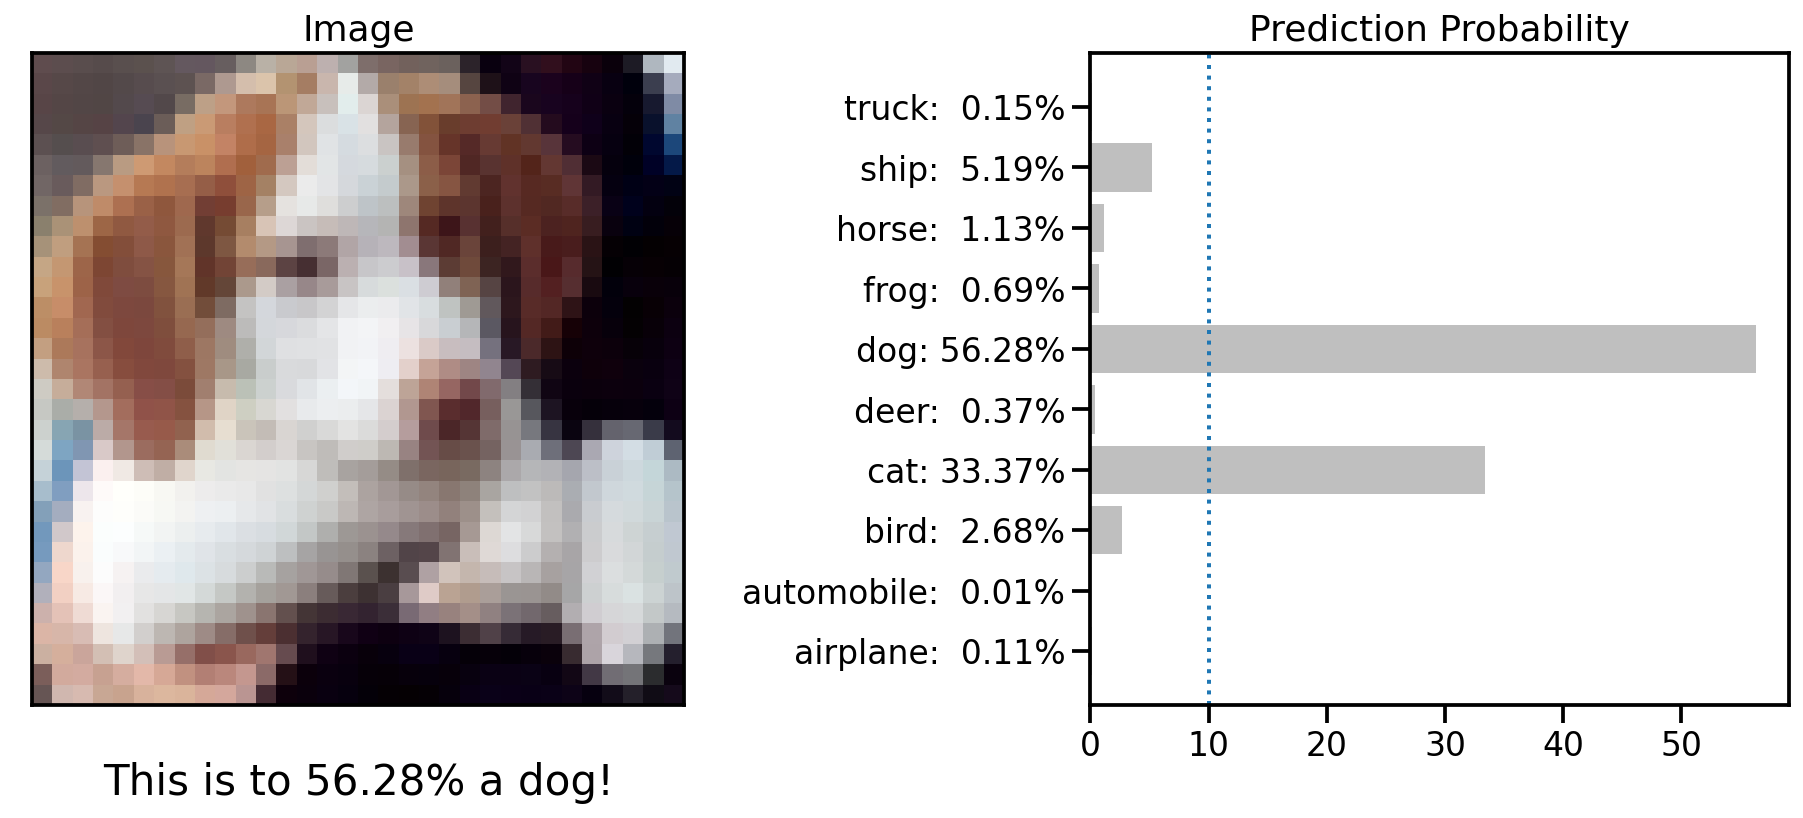

<IPython.core.display.Javascript object>

In [218]:
predict_single_image(model, x_test, y_te, labels, idx=16)

Much better! Actually, when we compute the overall accuracy this model would reach on a never before seen test set of 10'000 images, it reaches an average prediction accuracy of XYZ%.

In [219]:
loss, acc = model.evaluate(x_test, y_te)
print("Accuracy on test set: %f" % acc)

313/313 [==============================] - 3s 11ms/step - loss: 1.1656 - accuracy: 0.6589
Accuracy on test set: 0.658900


<IPython.core.display.Javascript object>

Last but not least, and for fun, let's select a few images from this test set and see how the individual prediction probabilities become more and more opinionated during training.

In [222]:
# Duplicate first and last figure to have a "resting phase" impression
!for i in {1..4}; do cp pred_000_0000.jpg pred_000_0000_$i.jpg; done
!for i in {1..4}; do cp pred_000_0048.jpg pred_000_0048_$i.jpg; done

<IPython.core.display.Javascript object>

In [223]:
!ffmpeg -y -framerate 4 -pattern_type glob -i 'pred_000_*.jpg' cnn_predictions.gif

ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with clang version 11.1.0
  configuration: --prefix=/Users/mnotter/opt/anaconda3/envs/medium --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --disable-openssl --enable-avresample --enable-demuxer=dash --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-libvpx --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/Users/runner/miniforge3/conda-bld/ffmpeg_1636205445100/_build_env/bin/pkg-config
  libavutil      56. 70.100 / 56. 70.100
  libavcodec     58.134.100 / 58.134.100
  libavformat    58. 76.100 / 58. 76.100
  libavdevice    58. 13.100 / 58. 13.100
  libavfilter     7.110.100 /  7.110.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  9.100 /  5.  9.100
  libswresample   3.  9.

<IPython.core.display.Javascript object>

In [221]:
from IPython.display import Image

Image(url="cnn_predictions.gif")

<IPython.core.display.Javascript object>

In [ ]:
# Removes temporary files
!rm conv_0*.jpg pred_0*.jpg temp.jpg